# Part d
This notebook contains a step-by-step walkthrough of task b) and c) using both code and text.

In [1]:
%load_ext autoreload
%autoreload 2
#Add own modules to path
import sys
sys.path.append('../..')
sys.path.append('../../src/')

### Loading the data and constructing the input matrix
In this part the publicly available Wisconsin Breast Cancer data set will be used for classification. The data set can be loaded directly from sklearn's library.
Each sample containts 30 features(e.g mean radius, mean texture etc) and a corresponding class(malignant or benign).

The design matrix is in this case simply the loaded data and is inputted to the network similarily as with regression. The target data is binary(0,1) is now binary as opposed to continuous. Here 0(negative) means malignant, and 1(positive) means benign.

Note that the arguments for scaling still holds, however it doesn't make sense to scale binary data. As such only the design matrix will be scaled.

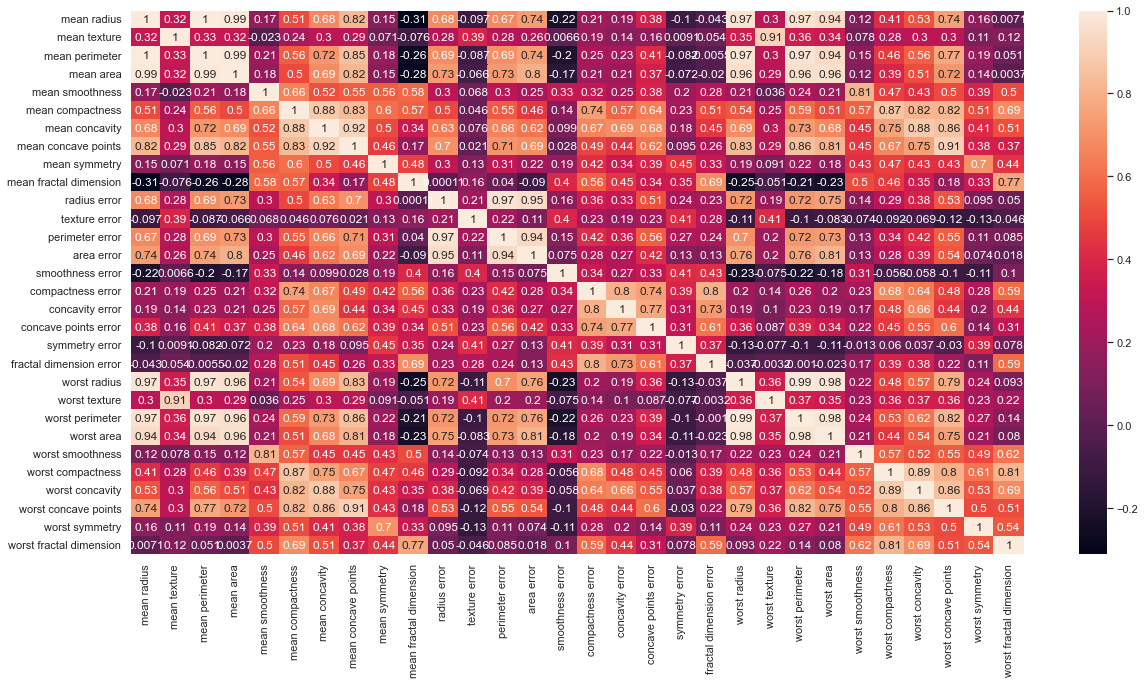

In [2]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='whitegrid')

data = load_breast_cancer()
X = data.data
z = data.target
data_df = pd.DataFrame(X, columns=data.feature_names)
corr = data_df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(data=corr, annot=True)
plt.show()

In [3]:
import numpy as np
z = z.reshape(-1,1)
print("Number of malignant samples:",z[z==0].shape[0], "Fraction:",z[z==0].shape[0]/z.shape[0])
print("Number of benign samples:",z[z==1].shape[0], "Fraction:",z[z==1].shape[0]/z.shape[0])

Number of malignant samples: 212 Fraction: 0.37258347978910367
Number of benign samples: 357 Fraction: 0.6274165202108963


Above print out shows the amount of samples of each of the classe. Note also the fraction of the classes. If one guesses benign on all cases, one would get about 62.7\% correct. Similarliy guessing only malignant would make you about 37.3\% right. In this case, this would also be the accurcies of those guesses.

In [4]:
from src.model_evaluation.metrics import accuracy
guess_benign = np.ones(z.shape)
guess_malignant = np.zeros(z.shape)
print("Accuracy when guessing only benign:", accuracy(z,guess_benign))
print("Accuracy when guessing only malignant:", accuracy(z,guess_malignant))

Accuracy when guessing only benign: 0.6274165202108963
Accuracy when guessing only malignant: 0.37258347978910367


### Confusion matrix
A confusion matrix is a n_classes-by-n_classes grid showing the predictions vs the truths. x-axis shows the predicted labels while y-axis show the truth. A confusion matrix is also sometimes called a truth table and it is useful to study how the predictions went wrong.

Prediction = 1 and truth = 1, is called a true positive(TP)

Prediction = 1 and truth = 0, is called a false positive(FP)

Prediction = 0 and truth = 1, is called a false negative(FN)

Prediction = 0 and truth = 0, is called a true negative(TN)

<AxesSubplot:>

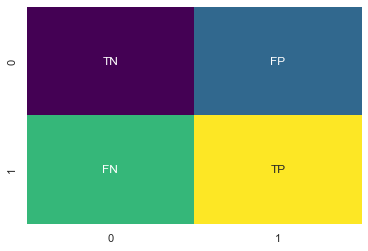

In [5]:
conf = np.array([[0,1],[2,3]])
lab = np.array([['TN','FP'],['FN','TP']])

sns.heatmap(conf,cmap="viridis",annot =lab,fmt='',cbar=False)

It is not always that maximizing accuracy is the only target. It depends on the classification problem. In this case, it is perhaps most dangerous with False positives, meaning prediction says bening, but truth is malignant. This could lead to a malignant cancer going undetected if one trusts the prediction. One might strive to create a model that minimizes FP instead. This would in turn lead to a model with a lot of False negatives, such that the model predicts malignant in many benign cases. This also has it's tolls as it might cause too many cases for the medical professionals to further study, leaving them unable to focus on the actual malignant ones.

One could then argue that maximizing true negatives while minimizing false negatives should be the main target, so that the medical professionals can use the models in addition to the already established practices.

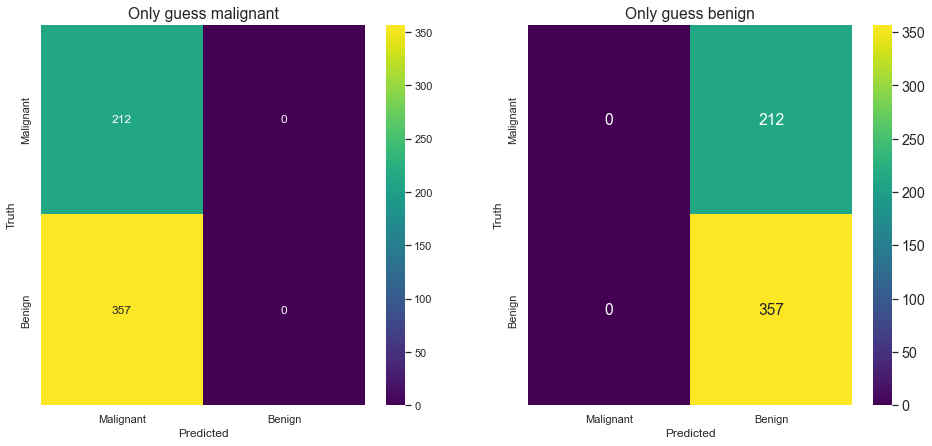

In [6]:
from src.visualization.visualize import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,7))
ax1 = plot_confusion_matrix(z,guess_malignant,ax=ax1,title = 'Only guess malignant')
ax2 = plot_confusion_matrix(z,guess_benign,ax=ax2, title = 'Only guess benign')

## Neural network classification
By changing the activation function in the output layer to one that maps the values between 0 and 1, one could obtain a probability of a certain class instead. In the case of binary classification sigmoid is used. Now the loss function to minimize is cross entropy instead of squared loss.

Train accuracy:  0.9868131868131869
Test accuracy:  0.9824561403508771


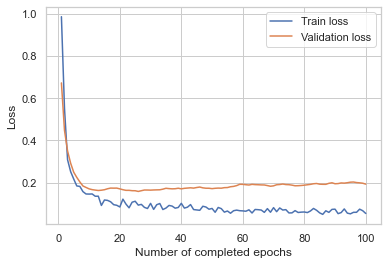

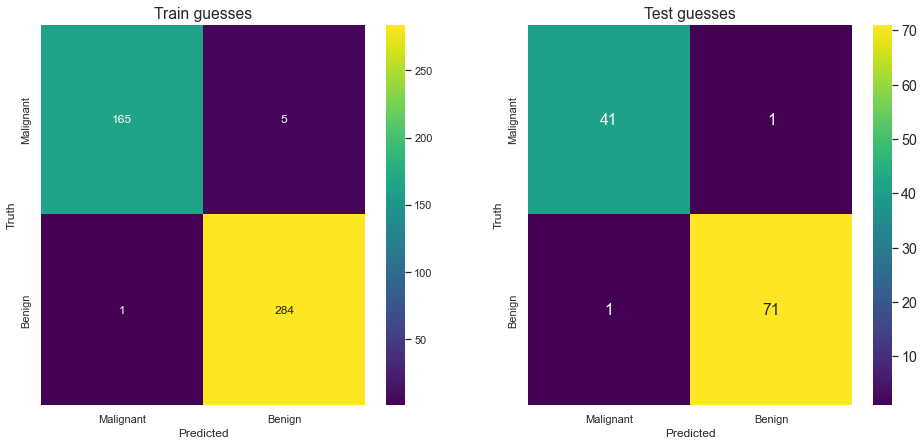

In [33]:
from src.modelling.nn import NeuralNetwork
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
sns.set_theme(style='whitegrid')

X_train,X_test,z_train,z_test = train_test_split(X,z,test_size=0.2)
X_scl = StandardScaler().fit(X_train)
X_train = X_scl.transform(X_train)
X_test = X_scl.transform(X_test)

#Model parameters
hidden_layer_sizes = (50,)
hidden_activation = 'sigmoid'
w_init='normal'
lmb = 0.001
momentum = 0.9
schedule = 'constant'
lr0 = 0.01
batch_size=32
n_epochs=100

nn = NeuralNetwork(hidden_layer_sizes = hidden_layer_sizes,
                   hidden_activation = hidden_activation,
                   output_activation = 'sigmoid',
                   w_init=w_init,
                   lmb = lmb,
                   momentum = momentum,
                   schedule = schedule,
                   lr0 = lr0,
                   batch_size=batch_size,
                   n_epochs=n_epochs)
nn.fit(X_train,z_train)
nn.plot_loss()


print("Train accuracy: ",nn.score(X_train,z_train))
print("Test accuracy: ",nn.score(X_test,z_test))

fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,7))
ax1 = plot_confusion_matrix(z_train,nn.predict(X_train),ax=ax1,title = 'Train guesses')
ax2 = plot_confusion_matrix(z_test,nn.predict(X_test),ax=ax2, title = 'Test guesses')

The network is immediatly able to predict quite well on the data. One thing to notice is that there are more False Positives on train guesses. I.e the model is somewhat biased towards benign.

From the learning curve it can be seen that the validation score is in fact increasing after a certain number of epochs. This may indicate that the model is starting to overfit. Early stopping can be applied to stop the training once validation score increases to some degree. However, using another activation function and initialization may help.

Train accuracy:  0.9934065934065934
Test accuracy:  0.9649122807017544


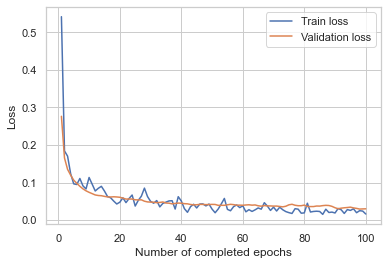

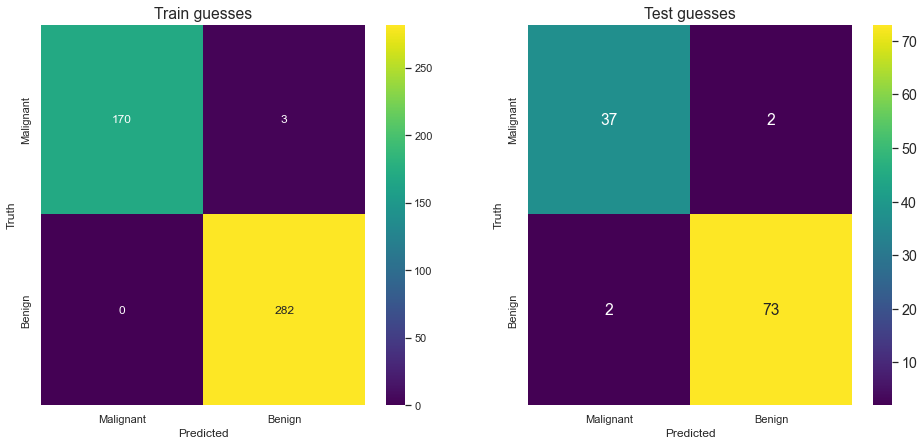

In [28]:
sns.set_theme(style='whitegrid')

X_train,X_test,z_train,z_test = train_test_split(X,z,test_size=0.2)
X_scl = StandardScaler().fit(X_train)
X_train = X_scl.transform(X_train)
X_test = X_scl.transform(X_test)

#Model parameters
hidden_layer_sizes = (50,)
hidden_activation = 'relu'
w_init='glorot'
lmb = 0.001
momentum = 0.9
schedule = 'constant'
lr0 = 0.01
batch_size=32
n_epochs=100

nn = nn.set_params(hidden_layer_sizes = hidden_layer_sizes,
                   hidden_activation = hidden_activation,
                   w_init=w_init,
                   lmb = lmb,
                   momentum = momentum,
                   schedule = schedule,
                   lr0 = lr0,
                   batch_size=batch_size,
                   n_epochs=n_epochs)

nn.fit(X_train,z_train)
nn.plot_loss()

print("Train accuracy: ",nn.score(X_train,z_train))
print("Test accuracy: ",nn.score(X_test,z_test))

fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,7))
ax1 = plot_confusion_matrix(z_train,nn.predict(X_train),ax=ax1,title = 'Train guesses')
ax2 = plot_confusion_matrix(z_test,nn.predict(X_test),ax=ax2, title = 'Test guesses')

The validation score seems somewhat more stable. However, it is not a huge amount of data, and so it can be rather random from run to run how the validation score acts.

#### Gridsearching lambda vs learning rate
A grid search is conducted to optimize lambda and learning rate.

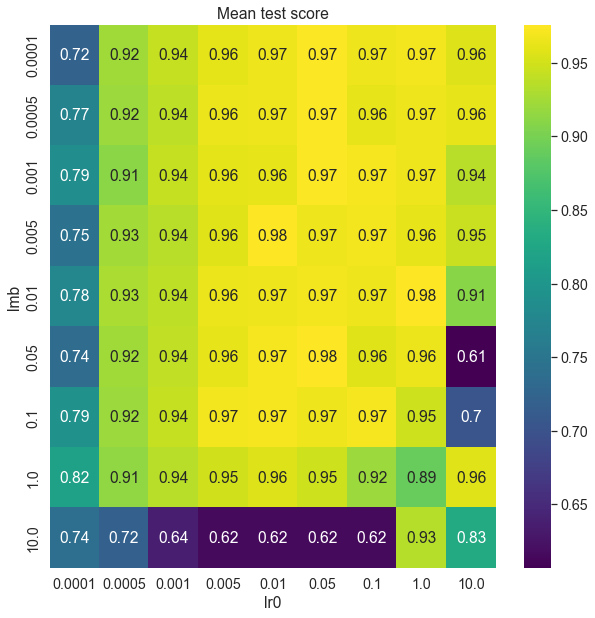

lmb                0.010000
lr0                       1
mean_test_score    0.975824
rank_test_score           1
Name: 43, dtype: object


In [108]:
from src.model_evaluation.param_analysis import grid_search_df
from src.visualization.visualize import plot_grid_search

X_train,X_test,z_train,z_test = train_test_split(X,z,test_size=0.2)
X_scl = StandardScaler().fit(X_train)
X_train = X_scl.transform(X_train)
X_test = X_scl.transform(X_test)

lambdas = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,1,10]
lrs = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,1,10]

#Model parameters
hidden_layer_sizes = (50,)
hidden_activation = 'sigmoid'
w_init='glorot'
lmb = 0.001
momentum = 0.9
schedule = 'constant'
lr0 = 0.001
batch_size=64
n_epochs=100

nn = nn.set_params(hidden_layer_sizes = hidden_layer_sizes,
                   hidden_activation = hidden_activation,
                   w_init=w_init,
                   lmb = lmb,
                   momentum = momentum,
                   lr0 = lr0,
                   batch_size=batch_size,
                   n_epochs=n_epochs)

best_model, scores = grid_search_df(X_train,z_train,nn, param_grid=dict(lmb=lambdas,lr0=lrs))
plot_grid_search(scores,('lmb','lr0'))
print(scores.loc[scores['rank_test_score'].idxmin()])

From the plot above it can be seen that lmb=0.01 and lr0=1 seems to achieve the best results. Even with lr0=10 the model is still able to achieve good results. It is unclear as to why, one would think a high learning rate would cause divergence. However, it might be that sklearn's GridSearchCV employs methods to ensure numerical stability. In that case, some of the weights might be either very high or low, thereby saturating the signal through sigmoid to either 1 or 0. If that is the case, then perhaps the problem is not necessarily a hard problem, and that the features themselves are very good indicators of class.

In [117]:
from sklearn.neural_network import MLPClassifier
nn_sk = MLPClassifier(hidden_layer_sizes=(50,),solver='sgd', 
                      batch_size = 64, learning_rate_init=10,
                      alpha=0.001,activation='logistic',tol=0)
nn_sk.fit(X_train,z_train.reshape(-1,1))
print(nn_sk.score(X_test,z_test.reshape(-1,1)))
nn_sk.coefs_

0.9736842105263158


c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[array([[ -0.16708139,   4.63710493,  -2.78940541, ...,  -0.30021984,
           4.64366359,  -6.17269156],
        [  1.18925444,  -8.05644266,   1.70801272, ...,  14.90177309,
          11.07523437,  -2.43621022],
        [ -0.44183815,   5.3581188 ,  -2.91512667, ...,  -0.13139819,
           5.01436587,  -5.99822184],
        ...,
        [ -4.60223965,   3.51481794, -13.0351515 , ...,  -0.27380088,
         -11.02293966,  -1.90472953],
        [ -3.66186646,   6.48149755,  -6.8444148 , ...,  -0.28274714,
          28.91559846,   3.51749682],
        [ -5.49242634,   5.77931925, -13.98519236, ...,  -1.03675992,
           4.09306513,   3.73770188]]),
 array([[  6.26484723],
        [-15.51462102],
        [ 17.06847385],
        [ 12.21889981],
        [ -0.15866143],
        [  6.67614379],
        [ 13.82296017],
        [-26.15764109],
        [ 16.26796602],
        [ -1.55793133],
        [ 15.01652818],
        [  8.25912513],
        [-23.56960731],
        [ 23.24936778],
 

By fitting an sklearn model with learning rate 10, we see that the weights are indeed quite inflated while the test score is 0.97. Many of these weights will result in a signal of 1 or 0. Perhaps this indicates that it is a clear cut between the features and that a simple logistic regression is enough, which will be explored later. It must be noted that fully saturated activations aren't really able to learn the smaller intricacies in the data, and using lower lr to achieve more stable weights might increase the score. Note that using relu will reslut in exploding gradients as it does not saturate at 1.

In [122]:
nn_sk = MLPClassifier(hidden_layer_sizes=(50,),solver='sgd', 
                      batch_size = 64, learning_rate_init=10,
                      alpha=0.001,activation='relu',tol=0)
nn_sk.fit(X_train,z_train.reshape(-1,1))
print(nn_sk.score(X_test,z_test.reshape(-1,1)))
nn_sk.coefs_

0.6754385964912281


c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[array([[2.84439134e+140, 2.17122070e+138, 7.78259212e+137, ...,
         7.43955472e+138, 1.23317009e+139, 1.92203081e+136],
        [1.27859696e+140, 9.75996567e+137, 3.49839294e+137, ...,
         3.34419244e+138, 5.54328620e+138, 8.63981939e+135],
        [2.90720186e+140, 2.21916610e+138, 7.95444913e+137, ...,
         7.60383670e+138, 1.26040124e+139, 1.96447354e+136],
        ...,
        [2.73971621e+140, 2.09131862e+138, 7.49618855e+137, ...,
         7.16577511e+138, 1.18778877e+139, 1.85129905e+136],
        [1.45762399e+140, 1.11265399e+138, 3.98823214e+137, ...,
         3.81244074e+138, 6.31944797e+138, 9.84955262e+135],
        [1.75778739e+140, 1.34177893e+138, 4.80951480e+137, ...,
         4.59752329e+138, 7.62078974e+138, 1.18778365e+136]]),
 array([[1.01935082e+141],
        [7.78105167e+138],
        [2.78906475e+138],
        [7.01965220e+140],
        [1.46325154e+141],
        [9.45974847e+140],
        [7.56959870e+140],
        [1.37485435e+141],
        [4.68

The score is also 0.64, close to the total fraction of benign, indicating it's only guessing 1.
Going forward, the aim will be to tune a model using relu as activation function. This will make it more clear if the weights are stable or not.

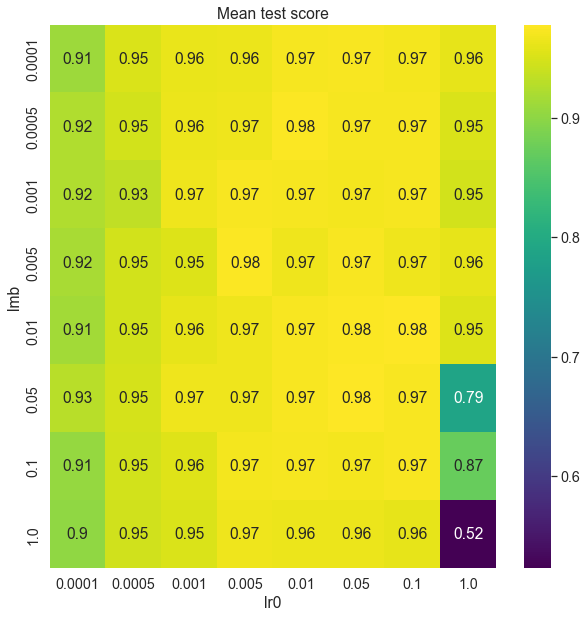

lmb                0.010000
lr0                0.100000
mean_test_score    0.978022
rank_test_score           1
Name: 38, dtype: object


In [120]:
sns.set_theme(style='whitegrid')

lambdas = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,1]
lrs = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,1]

#Model parameters
hidden_layer_sizes = (50,)
hidden_activation = 'relu'
w_init='glorot'
lmb = 0.001
momentum = 0.9
schedule = 'constant'
lr0 = 0.001
batch_size=64
n_epochs=100

nn = nn.set_params(hidden_layer_sizes = hidden_layer_sizes,
                   hidden_activation = hidden_activation,
                   w_init=w_init,
                   lmb = lmb,
                   momentum = momentum,
                   lr0 = lr0,
                   batch_size=batch_size,
                   n_epochs=n_epochs)

best_model, scores = grid_search_df(X_train,z_train,nn, param_grid=dict(lmb=lambdas,lr0=lrs))
plot_grid_search(scores,('lmb','lr0'))
print(scores.loc[scores['rank_test_score'].idxmin()])

lmb = 0.01 and lr0=0.1 seems to yield the best result. However, lr0=0.05 seems to achieve better results across several lmbs. For stability, lr0=0.05 is chosen together with lmb =0.01 going forward.

0.9736842105263158


(114, 1)

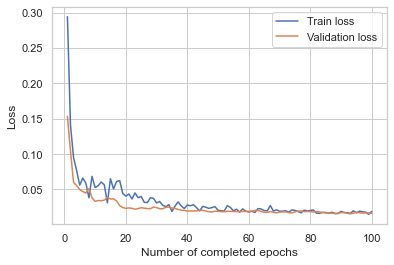

In [126]:
sns.set_theme(style='whitegrid')
#Model parameters
hidden_layer_sizes = (50,)
hidden_activation = 'relu'
w_init='glorot'
lmb = 0.01
momentum = 0.9
schedule = 'constant'
lr0 = 0.05
batch_size=32
n_epochs=100

nn = nn.set_params(hidden_layer_sizes = hidden_layer_sizes,
                   hidden_activation = hidden_activation,
                   w_init=w_init,
                   lmb = lmb,
                   momentum = momentum,
                   schedule = schedule,
                   lr0 = lr0,
                   batch_size=batch_size,
                   n_epochs=n_epochs)

nn.fit(X_train,z_train)
nn.plot_loss()

The learning curve does not indicate overfit.

Train accuracy:  1.0
Test accuracy:  0.9736842105263158


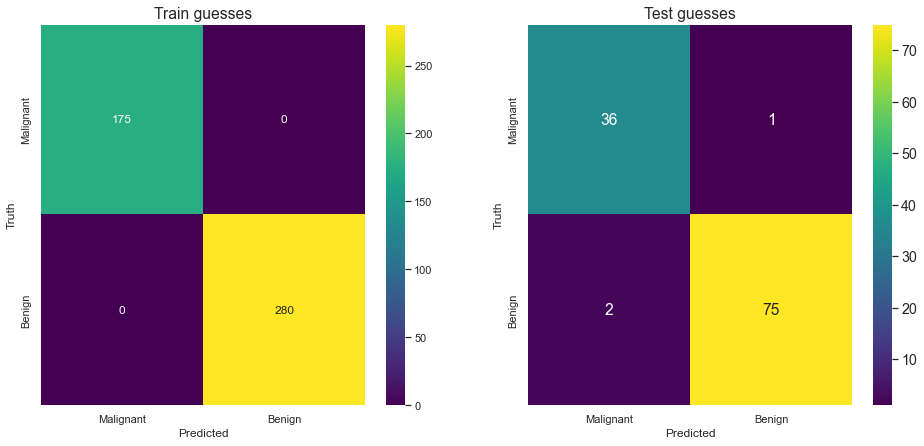

In [127]:
print("Train accuracy: ",nn.score(X_train,z_train))
print("Test accuracy: ",nn.score(X_test,z_test))

fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,7))
ax1 = plot_confusion_matrix(z_train,nn.predict(X_train),ax=ax1,title = 'Train guesses')
ax2 = plot_confusion_matrix(z_test,nn.predict(X_test),ax=ax2, title = 'Test guesses')

The model actually gets all train samples correct. That is often an indicator of overfit, however, when looking at test score 0.97, it seems the model has learned a lot from the data.
#### Benchmarking nn

In [128]:
from src.model_evaluation.resampling import cross_val_score

#Model parameters
hidden_layer_sizes = (50,)
hidden_activation = 'relu'
w_init='glorot'
lmb = 0.01
momentum = 0.9
schedule = 'constant'
lr0 = 0.05
batch_size=32
n_epochs=100

nn = nn.set_params(hidden_layer_sizes = hidden_layer_sizes,
                hidden_activation = hidden_activation,
                w_init=w_init,
                lmb = lmb,
                momentum = momentum,
                schedule = schedule,
                lr0 = lr0,
                batch_size=batch_size,
                n_epochs=n_epochs)

nn_scores =  cross_val_score(nn,X,z,5,X_scl,metrics=['accuracy'])
print('CV results:\n')
print('NN accuracy[train,test]:',(nn_scores['train']['accuracy'], nn_scores['test']['accuracy']))

CV results:

NN accuracy[train,test]: (0.9986822826296511, 0.971883247942866)


The crossvalidation shows a good score for both train and test. The test score even though high, may possibly be improved further.
#### Gridsearching architecture vs batch size

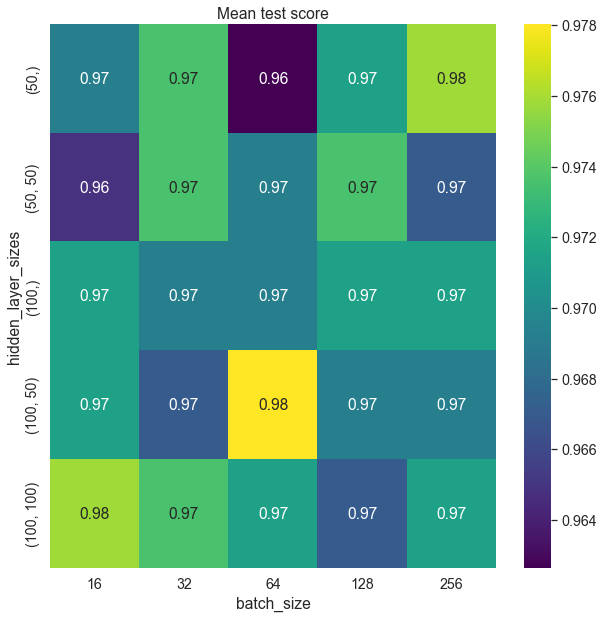

hidden_layer_sizes    (100, 50)
batch_size                   64
mean_test_score        0.978022
rank_test_score               1
Name: 13, dtype: object


In [132]:
hidden_layers_list = [(50,),(100,),(50,50),(100,50),(100,100)]
batch_sizes = [16, 32, 64, 128, 256]

best_model, scores = grid_search_df(X_train,z_train,nn, param_grid=dict(hidden_layer_sizes=hidden_layers_list,
                                                                        batch_size=batch_sizes))
plot_grid_search(scores,('hidden_layer_sizes','batch_size'))
print(scores.loc[scores['rank_test_score'].idxmin()])

Above results shows that most of the complexities tested gies around 0.97 in test score. However, (100,50) and batch size 64, seems to be score slightly higher than the rest, and will be used going forward.

#### Gridsearching activation function vs initialization of weights

../..\src\modelling\nn.py:458: RuntimeWarning: overflow encountered in matmul
  error = matmul(error, weights.T)*self.layers[0].derivative(self.layers[0].z_h,error)
../..\src\modelling\nn.py:458: RuntimeWarning: invalid value encountered in multiply
  error = matmul(error, weights.T)*self.layers[0].derivative(self.layers[0].z_h,error)
../..\src\modelling\nn.py:492: RuntimeWarning: invalid value encountered in matmul
  w_grad = matmul(prev_layer_a.T,error)
../..\src\modelling\nn.py:226: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * (w @ w) / (2*z.shape[0])
../..\src\modelling\nn.py:226: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * (w @ w) / (2*z.shape[0])
../..\src\modelling\nn.py:379: RuntimeWarning: overflow encountered in matmul
  layer.z_h = matmul(a,layer.weights) + layer.bias
../..\src\modelling\nn.py:492: RuntimeWarning: invalid value encountered in matmul
  w_grad = matmul(prev_layer_a.T,error)
../..\src\modelling\nn.py:458: RuntimeWa

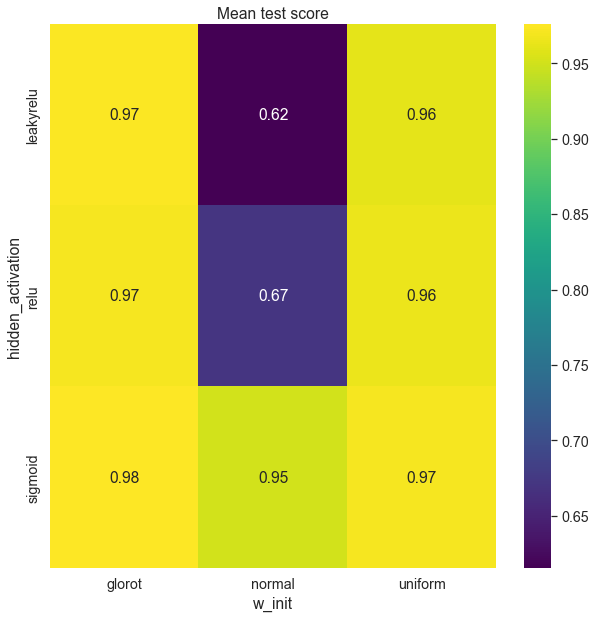

hidden_activation     sigmoid
w_init                 glorot
mean_test_score      0.975824
rank_test_score             1
Name: 6, dtype: object


In [134]:
activation_funcs = ['relu','leakyrelu','sigmoid']
w_inits = ['glorot','uniform','normal']

#Model parameters
hidden_layer_sizes = (100, 50)
hidden_activation = 'relu'
w_init='glorot'
lmb = 0.01
momentum = 0.9
schedule = 'constant'
lr0 = 0.05
batch_size=64
n_epochs=100

nn = nn.set_params(hidden_layer_sizes = hidden_layer_sizes,
                hidden_activation = hidden_activation,
                w_init=w_init,
                lmb = lmb,
                momentum = momentum,
                schedule = schedule,
                lr0 = lr0,
                batch_size=batch_size,
                n_epochs=n_epochs)

best_model, scores = grid_search_df(X_train,z_train,nn, param_grid=dict(hidden_activation=activation_funcs,w_init=w_inits))
plot_grid_search(scores,('hidden_activation','w_init'))
print(scores.loc[scores['rank_test_score'].idxmin()])

Sigmoid together with glorot initialization does give the best results in the grid search in the end. Note that the normal initialization scheme is not good at handeling either relu or leakyrelu.

<AxesSubplot:xlabel='Number of completed epochs', ylabel='Loss'>

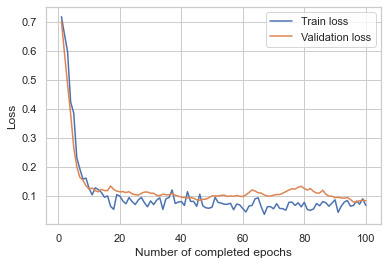

In [149]:
sns.set_theme(style='whitegrid')
#Model parameters
hidden_layer_sizes = (100,50)
hidden_activation = 'sigmoid'
w_init='glorot'
lmb = 0.01
momentum = 0.9
schedule = 'constant'
lr0 = 0.05
batch_size=64
n_epochs=100

nn = nn.set_params(hidden_layer_sizes = hidden_layer_sizes,
                hidden_activation = hidden_activation,
                w_init=w_init,
                lmb = lmb,
                momentum = momentum,
                schedule = schedule,
                lr0 = lr0,
                batch_size=batch_size,
                n_epochs=n_epochs)
nn.fit(X_train,z_train)
nn.plot_loss()

Note that it is with 100 epochs that this current model achieves good results. If increasing to 1000

<AxesSubplot:xlabel='Number of completed epochs', ylabel='Loss'>

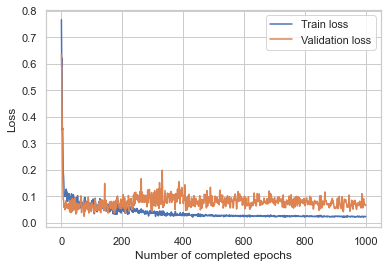

In [155]:
sns.set_theme(style='whitegrid')
#Model parameters
hidden_layer_sizes = (100,50)
hidden_activation = 'sigmoid'
w_init='glorot'
lmb = 0.01
momentum = 0.9
schedule = 'constant'
lr0 = 0.05
batch_size=64
n_epochs=1000

nn = nn.set_params(hidden_layer_sizes = hidden_layer_sizes,
                hidden_activation = hidden_activation,
                w_init=w_init,
                lmb = lmb,
                momentum = momentum,
                schedule = schedule,
                lr0 = lr0,
                batch_size=batch_size,
                n_epochs=n_epochs)
nn.fit(X_train,z_train)
nn.plot_loss()

Increasing epochs too much may cause overfit with current model complexity. However it seems 200 epochs should improve.

### Benchmarking and comparing to sklearn

In [164]:
#Model parameters
hidden_layer_sizes = (100, 50)
hidden_activation = 'sigmoid'
w_init='glorot'
lmb = 0.01
momentum = 0.9
schedule = 'constant'
lr0 = 0.05
batch_size=64
n_epochs=100

nn = nn.set_params(hidden_layer_sizes = hidden_layer_sizes,
                hidden_activation = hidden_activation,
                w_init=w_init,
                lmb = lmb,
                momentum = momentum,
                schedule = schedule,
                lr0 = lr0,
                batch_size=batch_size,
                n_epochs=n_epochs)

nn_sk = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,solver='sgd', 
                      batch_size = batch_size, learning_rate_init=lr0,
                      alpha=lmb,tol=0,max_iter = n_epochs,
                      activation = 'logistic')

nn_scores =  cross_val_score(nn,X,z,5,X_scl,metrics=['accuracy'])
nn_sk_scores =  cross_val_score(nn_sk,X,z,5,X_scl,metrics=['accuracy'])
print('CV results:\n')
print('NN accuracy[train,test]:',(nn_scores['train']['accuracy'], nn_scores['test']['accuracy']))
print('NN sk accuracy[train,test]:',(nn_sk_scores['train']['accuracy'], nn_sk_scores['test']['accuracy']))

c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Op

CV results:

NN accuracy[train,test]: (0.9859379217273954, 0.9648657040832169)
NN sk accuracy[train,test]: (0.9885772122614227, 0.9665890389691041)


c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


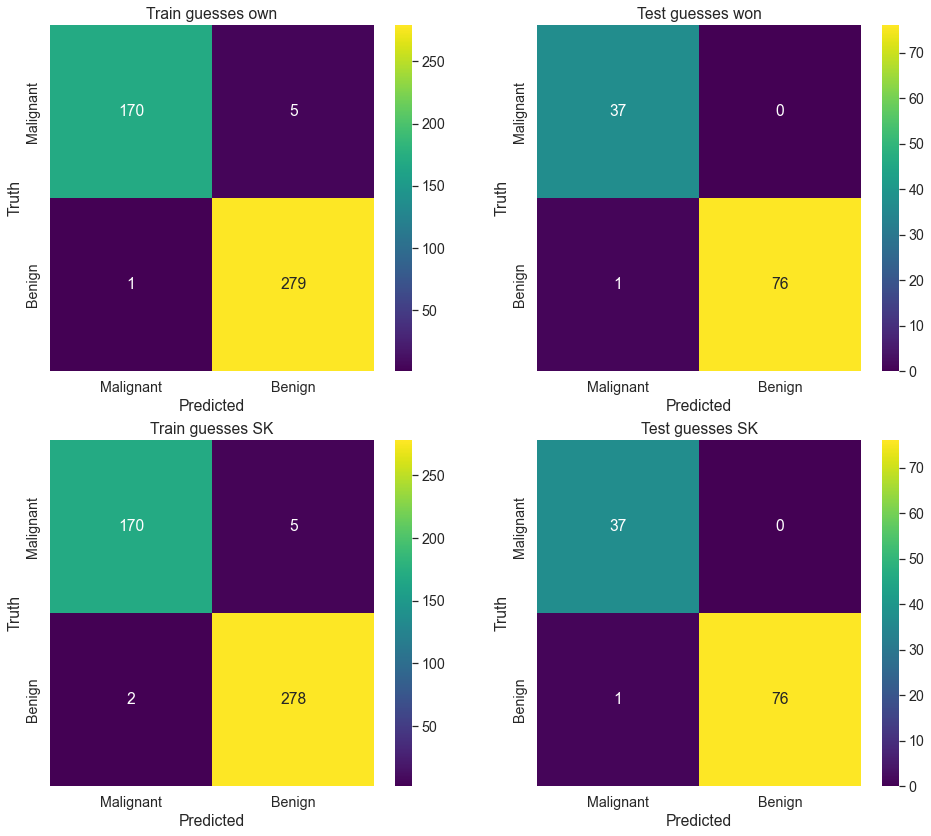

In [167]:
nn.fit(X_train,z_train)
nn_sk.fit(X_train,z_train)

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize = (16,14))
ax1 = plot_confusion_matrix(z_train,nn.predict(X_train),ax=ax1,title = 'Train guesses own')
ax2 = plot_confusion_matrix(z_test,nn.predict(X_test),ax=ax2, title = 'Test guesses won')
      
ax3 = plot_confusion_matrix(z_train,nn_sk.predict(X_train),ax=ax3,title = 'Train guesses SK')
ax4 = plot_confusion_matrix(z_test,nn_sk.predict(X_test),ax=ax4, title = 'Test guesses SK')

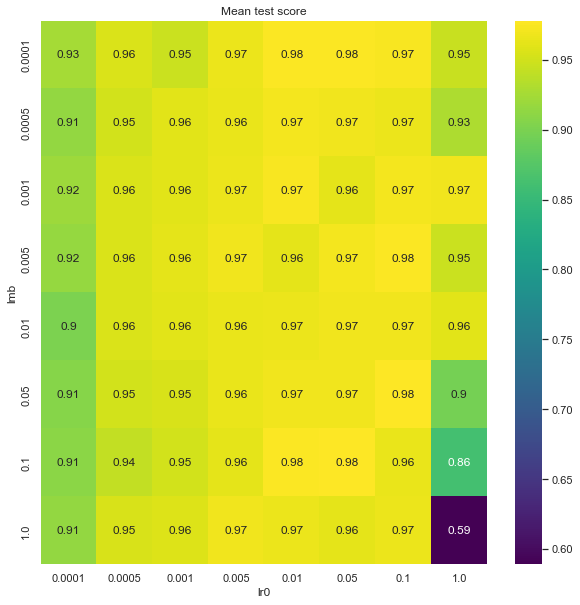

lmb                0.050000
lr0                0.100000
mean_test_score    0.978022
rank_test_score           1
Name: 46, dtype: object


In [168]:
sns.set_theme(style='whitegrid')

lambdas = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,1]
lrs = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,1]

#Model parameters
hidden_layer_sizes = (50,)
hidden_activation = 'relu'
w_init='glorot'
lmb = 0.001
momentum = 0.9
schedule = 'constant'
lr0 = 0.001
batch_size=64
n_epochs=100

nn = nn.set_params(hidden_layer_sizes = hidden_layer_sizes,
                   hidden_activation = hidden_activation,
                   w_init=w_init,
                   lmb = lmb,
                   momentum = momentum,
                   lr0 = lr0,
                   batch_size=batch_size,
                   n_epochs=n_epochs)

best_model, scores = grid_search_df(X_train,z_train,nn, param_grid=dict(lmb=lambdas,lr0=lrs))
plot_grid_search(scores,('lmb','lr0'))
print(scores.loc[scores['rank_test_score'].idxmin()])